In [1]:
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchvision
from torchvision import transforms

In [2]:
class PNGFolderDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        super().__init__()
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = sorted(
            glob.glob(os.path.join(root_dir, "*.png"))
        )
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img

data_root = "data"  

transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])

dataset = PNGFolderDataset(root_dir=data_root, transform=transform)
batch_size = 64

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)
print("Число картинок в датасете:", len(dataset))

device: cuda
Число картинок в датасете: 21551


In [3]:
nz = 100 
ngf = 64  
ndf = 64  
num_epochs = 5

class Generator(nn.Module):
    def __init__(self, nz, ngf, nc=3):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, x):
        return self.main(x)

class Discriminator(nn.Module):
    def __init__(self, ndf, nc=3):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.main(x).view(-1)

In [4]:
netG = Generator(nz, ngf, nc=3).to(device)
netD = Discriminator(ndf, nc=3).to(device)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

netG.apply(weights_init)
netD.apply(weights_init)

criterion = nn.BCELoss()

lr = 0.0002
beta1 = 0.5
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))

In [5]:
fixed_noise = torch.randn(36, nz, 1, 1, device=device)

G_losses = []
D_losses = []

print("Начинаем обучение DCGAN...")
for epoch in range(num_epochs):
    for i, real_imgs in enumerate(dataloader):
        b_size = real_imgs.size(0)
        real_imgs = real_imgs.to(device)
        
        label_real = torch.ones(b_size, device=device)
        label_fake = torch.zeros(b_size, device=device)

        netD.zero_grad()
        
        output_real = netD(real_imgs)  
        lossD_real = criterion(output_real, label_real)
        lossD_real.backward()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_imgs = netG(noise)
        output_fake = netD(fake_imgs.detach()) 
        lossD_fake = criterion(output_fake, label_fake)
        lossD_fake.backward()

        lossD = lossD_real + lossD_fake
        optimizerD.step()

        netG.zero_grad()
        output_for_G = netD(fake_imgs)  
        lossG = criterion(output_for_G, label_real)
        lossG.backward()
        optimizerG.step()
        
        G_losses.append(lossG.item())
        D_losses.append(lossD.item())

        if i % 50 == 0:
            print(f"[Epoch {epoch+1}/{num_epochs}][Batch {i}/{len(dataloader)}] "
                  f"LossD: {lossD.item():.4f}, LossG: {lossG.item():.4f}")

Начинаем обучение DCGAN...
[Epoch 1/5][Batch 0/337] LossD: 1.4315, LossG: 3.5941
[Epoch 1/5][Batch 50/337] LossD: 0.9484, LossG: 24.9091
[Epoch 1/5][Batch 100/337] LossD: 0.3674, LossG: 13.7848
[Epoch 1/5][Batch 150/337] LossD: 0.4438, LossG: 5.5440
[Epoch 1/5][Batch 200/337] LossD: 0.7977, LossG: 8.1087
[Epoch 1/5][Batch 250/337] LossD: 1.8448, LossG: 12.4508
[Epoch 1/5][Batch 300/337] LossD: 0.6924, LossG: 6.0503
[Epoch 2/5][Batch 0/337] LossD: 0.4806, LossG: 5.7322
[Epoch 2/5][Batch 50/337] LossD: 0.3427, LossG: 5.9976
[Epoch 2/5][Batch 100/337] LossD: 0.6352, LossG: 6.5646
[Epoch 2/5][Batch 150/337] LossD: 0.6314, LossG: 6.5853
[Epoch 2/5][Batch 200/337] LossD: 0.8755, LossG: 6.0570
[Epoch 2/5][Batch 250/337] LossD: 0.6451, LossG: 6.0433
[Epoch 2/5][Batch 300/337] LossD: 0.5251, LossG: 6.0699
[Epoch 3/5][Batch 0/337] LossD: 0.3037, LossG: 5.5360
[Epoch 3/5][Batch 50/337] LossD: 0.3691, LossG: 7.2120
[Epoch 3/5][Batch 100/337] LossD: 0.6033, LossG: 7.6004
[Epoch 3/5][Batch 150/337] 

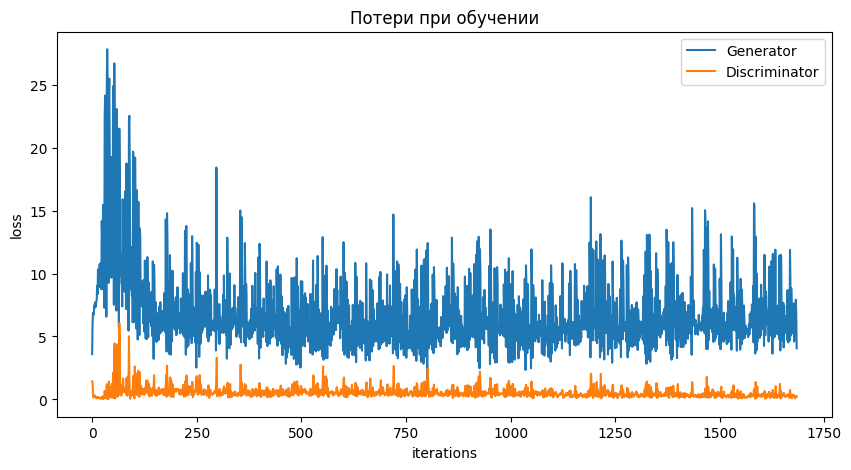

In [6]:
plt.figure(figsize=(10,5))
plt.title("Потери при обучении")
plt.plot(G_losses, label="Generator")
plt.plot(D_losses, label="Discriminator")
plt.xlabel("iterations")
plt.ylabel("loss")
plt.legend()
plt.show()

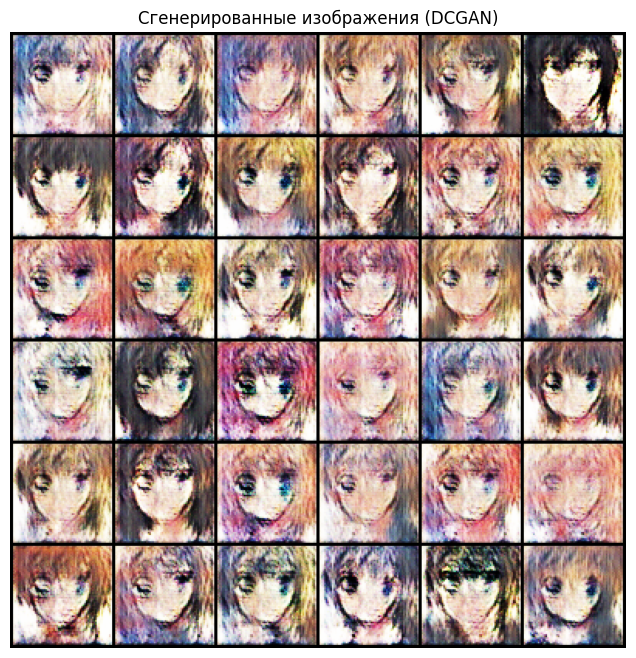

In [7]:
with torch.no_grad():
    fake_sample = netG(fixed_noise).cpu()

fake_grid = torchvision.utils.make_grid(fake_sample, nrow=6, normalize=True)
plt.figure(figsize=(8,8))
plt.imshow(np.transpose(fake_grid.numpy(), (1,2,0)))
plt.title("Сгенерированные изображения (DCGAN)")
plt.axis('off')
plt.show()